<a href="https://colab.research.google.com/github/RushabhShahPrograms/Image-Query-Image-Search/blob/main/Faiss_Image_Query_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install faiss-cpu -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 19.2 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/MizzleAa/Faiss-Image-Relation.git

Cloning into 'Faiss-Image-Relation'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 370 (delta 17), reused 35 (delta 11), pack-reused 327
Receiving objects: 100% (370/370), 52.11 MiB | 25.33 MiB/s, done.
Resolving deltas: 100% (28/28), done.


Query image: /content/Faiss-Image-Relation/dataset/test/8438-1_27_0_91.jpg
Similar images:
/content/Faiss-Image-Relation/dataset/train/flask/8438-1_27_2_171_302.jpg
/content/Faiss-Image-Relation/dataset/train/flask/5874-1_8_0_119_250.jpg
/content/Faiss-Image-Relation/dataset/train/flask/8615-3_58_0_73_204.jpg
/content/Faiss-Image-Relation/dataset/train/flask/5874-1_10_0_83_214.jpg
/content/Faiss-Image-Relation/dataset/train/flask/5874-1_8_0_75_206.jpg


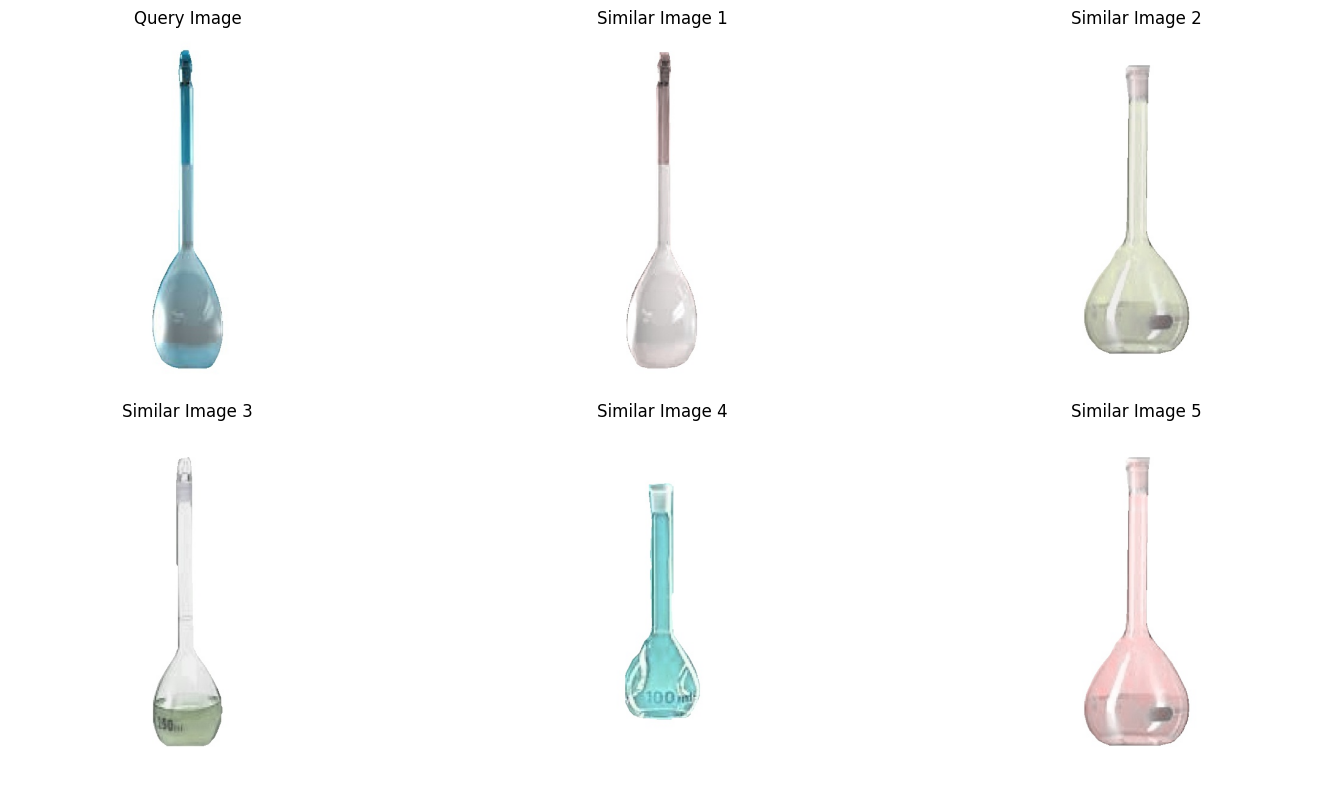

In [5]:
import os
import faiss
import numpy as np
from PIL import Image
from torchvision import transforms, models
import torch
import matplotlib.pyplot as plt

# Set up the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

def extract_features(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)

    with torch.no_grad():
        features = model(batch_t)

    return features.squeeze().numpy()

# Load and index images
def load_and_index_images(root_dir):
    image_paths = []
    features_list = []

    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                features = extract_features(img_path)

                image_paths.append(img_path)
                features_list.append(features)

    features_array = np.array(features_list).astype('float32')

    # Create FAISS index
    d = features_array.shape[1]  # dimension of features
    index = faiss.IndexFlatL2(d)
    index.add(features_array)

    return index, image_paths

# Search for similar images
def search_similar_images(index, image_paths, query_image_path, k=5):
    query_features = extract_features(query_image_path)
    query_features = query_features.reshape(1, -1).astype('float32')

    distances, indices = index.search(query_features, k)

    similar_images = [image_paths[i] for i in indices[0]]
    return similar_images

# Display images
def display_images(query_image_path, similar_images):
    fig = plt.figure(figsize=(15, 8))

    # Display query image
    ax = fig.add_subplot(2, 3, 1)
    query_img = Image.open(query_image_path)
    ax.imshow(query_img)
    ax.set_title("Query Image")
    ax.axis('off')

    # Display similar images
    for i, img_path in enumerate(similar_images):
        ax = fig.add_subplot(2, 3, i+2)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Similar Image {i+1}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    root_dir = "/content/Faiss-Image-Relation/dataset/train"
    index, image_paths = load_and_index_images(root_dir)

    query_image_path = "/content/Faiss-Image-Relation/dataset/test/8438-1_27_0_91.jpg"
    similar_images = search_similar_images(index, image_paths, query_image_path)

    print("Query image:", query_image_path)
    print("Similar images:")
    for img_path in similar_images:
        print(img_path)

    # Display the query image and similar images
    display_images(query_image_path, similar_images)

if __name__ == "__main__":
    main()